## **Module 3 Final Project**

    Title: Northwinds Database
    Submitted By: RU KEÏN
    Date: December 5, 2019
    Instructor: James Irving PhD
    https://vimeo.com/rukein/northwind-datascience-project-presentation
    http://www.hakkeray.com/datascience/2019/12/07/thinking-outside-the-lego-box.html

--------------------------
## Table of Contents

    1. Data Prep

    2. H1: Discount and Order Quantity
    Does discount amount have a statistically significant effect on quantity of product in an 
    order? If so, at what level(s) of discount?
        a. Hypotheses
        b. Data grouping
        c. Testing
        d. Results

    3. H2: Discount and Region/Country
    Do individual countries or regions show a statistically significant preference for 
    discount? If so, which countries and to what extent?
        a. Hypotheses
        b. Data grouping
        c. Testing
        d. Results

    4. H3: Time of Year and Revenue/Units Sold
    Does time of year have a statistically significant effect on sales? If so, which 
    months/seasons? Does this vary by region/country?
        a. Hypotheses
        b. Data grouping
           * average number of orders made
           * average order size (measured as quantities per order)
        c. Testing
        d. Results

    5. H4: Shipping Costs and Order Quantities/Sales Revenue
    Does cost of shipping (freight) have a statistically significant effect on quantity of a 
    product in an order? If so, at what level(s) of shipping cost?
        a. Hypotheses
        b. Data grouping
        c. Testing
        d. Results

    6. Results Analysis
        a. Hypotheses
        b. Data grouping
        c. Testing
        d. Results
    
    7. Recommendations and Conclusion

    8. Future Work/Additional Explorations
    A. Customer Satisfaction Improvement (On-time Shipments)
    B. Product Recommendation Tool
        * What are top 3 selling products overall vs each region/country).


## Data Prep

In [1]:
# install requisite libraries and packages
!pip install -U fsds_100719 --user
from fsds_100719.imports import *

fsds_1007219  v0.4.45 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [10]:
from fsds_100719.ds import ihelp, reload
import fsds_100719 as fs

In [11]:
def hot_stats(data, column, verbose=False, t=None):
    """
    Scans the values of a column within a dataframe and displays its datatype, 
    nulls (incl. pct of total), unique values, non-null value counts, and 
    statistical info (if the datatype is numeric).
    
    ---------------------------------------------
    
    Parameters:
    
    **args:
    
        data: accepts dataframe
    
        column: accepts name of column within dataframe (should be inside quotes '')
    
    **kwargs:
    
        verbose: (optional) accepts a boolean (default=False); verbose=True will display all 
        unique values found.   
    
        t: (optional) accepts column name as target to calculate correlation coefficient against 
        using pandas data.corr() function. 
    
    -------------
    
    Examples: 
    
    hot_stats(df, 'str_column') --> where df = data, 'string_column' = column you want to scan
    
    hot_stats(df, 'numeric_column', t='target') --> where 'target' = column to check correlation value
    
    -----------------
    Developer notes: additional features to add in the future:
    -get mode(s)
    -functionality for string objects
    -pass multiple columns at once and display all
    -----------------
    SAMPLE OUTPUT: 
    ****************************************
    
    -------->
    HOT!STATS
    <--------
    CONDITION
    Data Type: int64
    count    21597.000000
    mean         3.409825
    std          0.650546
    min          1.000000
    25%          3.000000
    50%          3.000000
    75%          4.000000
    max          5.000000
    Name: condition, dtype: float64 
    à-la-Mode: 
    0    3
    dtype: int64
    No Nulls Found!
    Non-Null Value Counts:
    3    14020
    4     5677
    5     1701
    2      170
    1       29
    Name: condition, dtype: int64
    # Unique Values: 5
    
    """
    # assigns variables to call later as shortcuts 
    feature = data[column]
    rdash = "-------->"
    ldash = "<--------"
    
    # figure out which hot_stats to display based on dtype 
    if feature.dtype == 'float':
        hot_stats = feature.describe().round(2)
    elif feature.dtype == 'int':
        hot_stats = feature.describe()
    elif feature.dtype == 'object' or 'category' or 'datetime64[ns]':
        hot_stats = feature.agg(['min','median','max'])
        t = None # ignores corr check for non-numeric dtypes by resetting t
    else:
        hot_stats = None

    # display statistics (returns different info depending on datatype)
    print(rdash)
    print("HOT!STATS")
    print(ldash)
    
    # display column name formatted with underline
    print(f"\n{feature.name.upper()}")
    
    # display the data type
    print(f"Data Type: {feature.dtype}\n")
    
    # display the mode
    print(hot_stats,"\n")
    print(f"à-la-Mode: \n{feature.mode()}\n")
    
    # find nulls and display total count and percentage
    if feature.isna().sum() > 0:  
        print(f"Found\n{feature.isna().sum()} Nulls out of {len(feature)}({round(feature.isna().sum()/len(feature)*100,2)}%)\n")
    else:
        print("\nNo Nulls Found!\n")
    
    # display value counts (non-nulls)
    print(f"Non-Null Value Counts:\n{feature.value_counts()}\n")
    
    # display count of unique values
    print(f"# Unique Values: {len(feature.unique())}\n")
    # displays all unique values found if verbose set to true
    if verbose == True:
        print(f"Unique Values:\n {feature.unique()}\n")
        
    # display correlation coefficient with target for numeric columns:
    if t != None:
        corr = feature.corr(data[t]).round(4)
        print(f"Correlation with {t.upper()}: {corr}") 

In [12]:
# connect to database / import data
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [13]:
# create dataframe of table names for referencing purposes
cur.execute("""SELECT name from sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [14]:
# function for converting tables into dataframes on the fly
def get_table(cur, table):
    cur.execute(f"SELECT * from {table};")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [desc[0] for desc in cur.description]
    return df

# H1: Discount--Order Quantity

* Does discount amount have a statistically significant effect on the quantity of a product in an order? 
* If so, at what level(s) of discount?

## Hypotheses
    
    𝐻1  : Discount amount has a statistically significant effect on the quantity in an order.

    𝐻0 : Discount amount has no relationship with the quantity of a product in an order.

## Data Grouping

In [17]:
# create dataframe from OrderDetail table since that is where the discount information is stored
cur.execute("""SELECT * FROM OrderDetail;""")
df_orderDetail = pd.DataFrame(cur.fetchall())
df_orderDetail.columns = [x[0] for x in cur.description]
df_orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [18]:
# insert boolean column into orderDetail showing whether or not an order includes a discount value
df_orderDetail['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)

In [20]:
df_orderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [21]:
# split order data into two groups: discounted and fullprice
fullprice = df_orderDetail.groupby('discounted').get_group(0)['Quantity']
discount = df_orderDetail.groupby('discounted').get_group(1)['Quantity']

## Testing

<BarContainer object of 1 artists>

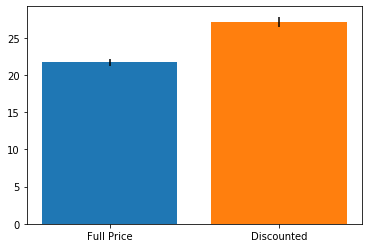

In [23]:
# Check if sample sizes allow us to ignore assumptions; if not, test assumption normality
# visualize sample size comparisons for two groups (normality check)
import scipy.stats as stat
plt.bar(x='Full Price', height=fullprice.mean(), yerr=stat.sem(fullprice))
plt.bar(x='Discounted', height=discount.mean(), yerr=stat.sem(discount))

In [24]:
# Test for normality
stat.normaltest(fullprice), stat.normaltest(discount)

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57))

In [25]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(fullprice, discount)

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

In [14]:
# Perform chosen statistical test, calculate effect size, and any post-hoc tests.

In [26]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_orderDetail['Quantity'].values
labels = df_orderDetail['Discount'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

In [27]:
# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
1,0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
2,0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
3,0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
4,0.0,0.05,6.2955,0.0011,1.5381,11.053,True
5,0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
6,0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
7,0.0,0.15,6.6669,0.0014,1.551,11.7828,True
8,0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
9,0.0,0.25,6.525,0.0023,1.3647,11.6852,True


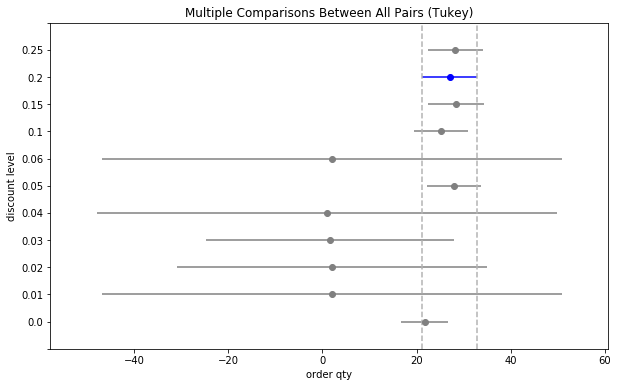

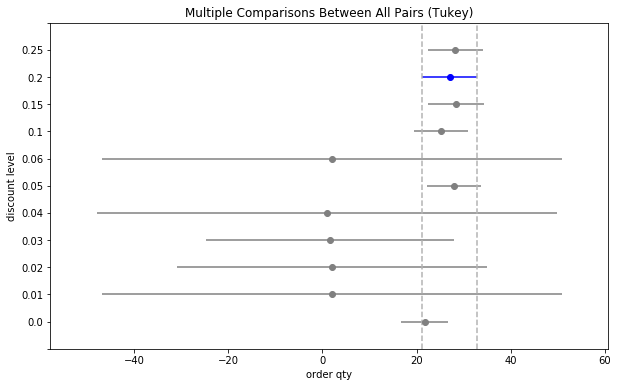

In [28]:
# Plot a universal confidence interval of each group mean comparing significant differences in group means. 
# Significant differences at the alpha=0.05 level can be identified by intervals that do not overlap 

oq_data = df_orderDetail['Quantity'].values
discount_labels = df_orderDetail['Discount'].values

from statsmodels.stats.multicomp import MultiComparison
oqd = MultiComparison(oq_data, discount_labels)
results = oqd.tukeyhsd()
results.plot_simultaneous(comparison_name=0.2, xlabel='order qty', ylabel='discount level')

## Results

Reject null hypothesis for discount and order quantity where discount = [0.05, 0.1, 0.15, 0.2, 0.25]

In [30]:
df_oqd = df_orderDetail.loc[(df_orderDetail['Discount'] >= 0.05) & (df_orderDetail['Discount'] != 0.06)]
df_oqd

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
6,10250/51,10250,51,42.4,35,0.15,1
7,10250/65,10250,65,16.8,15,0.15,1
8,10251/22,10251,22,16.8,6,0.05,1
9,10251/57,10251,57,15.6,15,0.05,1
11,10252/20,10252,20,64.8,40,0.05,1
...,...,...,...,...,...,...,...
2130,11077/2,11077,2,19.0,24,0.20,1
2134,11077/7,11077,7,30.0,1,0.05,1
2135,11077/8,11077,8,40.0,2,0.10,1
2137,11077/12,11077,12,38.0,2,0.05,1


(array([185., 173., 157., 315.]),
 array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <a list of 4 Patch objects>)

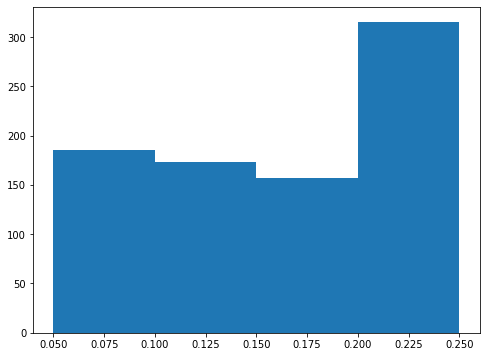

In [31]:
fig = plt.figure(figsize=(8,6))
plt.hist(data=df_oqd, x='Discount', bins=dv)

In [32]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [55]:
# dataframe containg full price only - no discount orders
fullprice_df = df_orderDetail.loc[df_orderDetail['discounted'] == 0]
discount_df = df_orderDetail.loc[df_orderDetail['discounted'] == 1]

In [56]:
Cohen_d(fullprice_df.Quantity, discount_df.Quantity)

-0.2862724481729282

In [64]:
discount25pct = df_oqd.loc[df_oqd['Discount'] == 0.25]
discount20pct = df_oqd.loc[df_oqd['Discount'] == 0.20]
discount15pct = df_oqd.loc[df_oqd['Discount'] == 0.15]
discount10pct = df_oqd.loc[df_oqd['Discount'] == 0.10]
discount5pct = df_oqd.loc[df_oqd['Discount'] == 0.5]

In [37]:
discount25pct['Quantity'].mean()

28.24025974025974

In [59]:
discount15pct['Quantity'].mean()

28.38216560509554

In [61]:
discount10pct['Quantity'].mean()

25.23699421965318

In [65]:
discount5pct['Quantity'].min()

nan

In [38]:
discount25pct['UnitPrice'].mean()

28.21441558441558

In [69]:
hot_stats(discount25pct, 'Quantity')

-------->
HOT!STATS
<--------

QUANTITY
Data Type: int64

count    154.00000
mean      28.24026
std       20.12057
min        2.00000
25%       15.00000
50%       25.00000
75%       36.00000
max      120.00000
Name: Quantity, dtype: float64 

à-la-Mode: 
0    30
dtype: int64


No Nulls Found!

Non-Null Value Counts:
30     19
20     15
15     11
40     11
35     10
21      8
25      7
60      7
50      7
18      5
12      5
2       5
10      5
4       5
5       4
70      3
6       2
3       2
7       2
24      2
100     2
36      2
42      2
44      2
16      1
27      1
14      1
28      1
11      1
9       1
8       1
49      1
65      1
80      1
120     1
Name: Quantity, dtype: int64

# Unique Values: 35



In [66]:
mean_qty_fullprice = fullprice_df.Quantity.mean()
mean_qty_discount = discount_df.Quantity.mean()
print(mean_qty_fullprice, mean_qty_discount)

21.715261958997722 27.10978520286396


In [68]:
diff = mean_qty_discount - mean_qty_fullprice
diff

5.394523243866239

In [53]:
from pandas_profiling import ProfileReport
#ProfileReport(df_oqd)

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


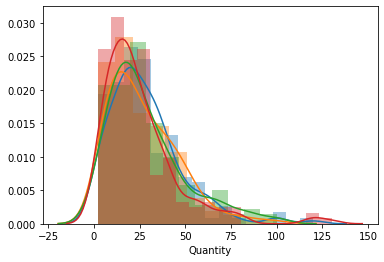

In [50]:
sns.distplot(discount25pct.Quantity)
sns.distplot(discount20pct.Quantity)
sns.distplot(discount15pct.Quantity)
sns.distplot(discount10pct.Quantity)
sns.distplot(discount5pct.Quantity)

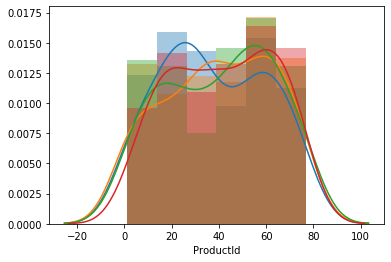

In [52]:
sns.distplot(discount25pct.ProductId)
sns.distplot(discount20pct.ProductId)
sns.distplot(discount15pct.ProductId)
sns.distplot(discount10pct.ProductId)
sns.distplot(discount5pct.ProductId)

# H2: Discount--Region/Country

**Do individual countries or regions show a statistically significant preference for discount?**

**If so, which countries and to what extent?** 

## Hypotheses

- $H_0$: Countries purchase equal quantities of discounted vs non-discounted products.

- $H_A$: Countries purchase different quantities of discounted vs non-discounted products.

## Data Grouping

In [80]:
df_order = get_table(cur, "'Order'")
display(df_order.head())
display(df_orderDetail.head())

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [82]:
# Rename 'Id' to 'OrderId' for joining tables with matching primary key name
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
display(df_order.head())

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [84]:
df_order.set_index('OrderId',inplace=True)
display(df_order.head())

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
OrderId,,,,,,,,,,,,,
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [85]:
df_countries = df_orderDetail.merge(df_order, on='OrderId', copy=True)

In [88]:
df = df_countries
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [89]:
grps = df.groupby('ShipCountry').groups
grps.keys()

dict_keys(['Argentina', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy', 'Mexico', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA', 'Venezuela'])

## Testing

Argentina is missing one of the groups.

Results for Austria:
Ttest_indResult(statistic=-0.6623269022307275, pvalue=0.5090008404811379)

Austria has no preference.


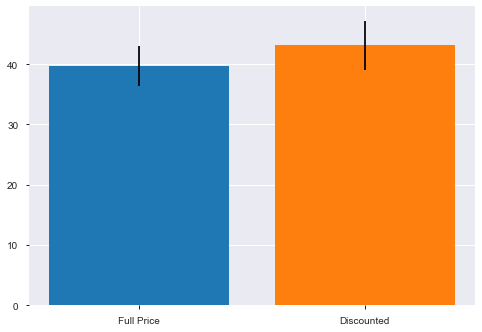


Results for Belgium:
Ttest_indResult(statistic=-1.3489126055424439, pvalue=0.18299467630787178)

Belgium has no preference.


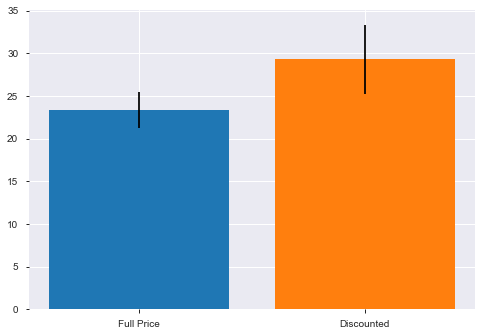


Results for Brazil:
Ttest_indResult(statistic=0.9101788952517438, pvalue=0.36381833828838683)

Brazil has no preference.


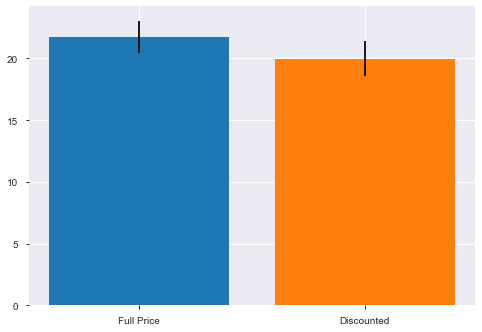


Results for Canada:
Ttest_indResult(statistic=-3.4195803456201843, pvalue=0.0010297982736886485)

Canada prefers discounts!


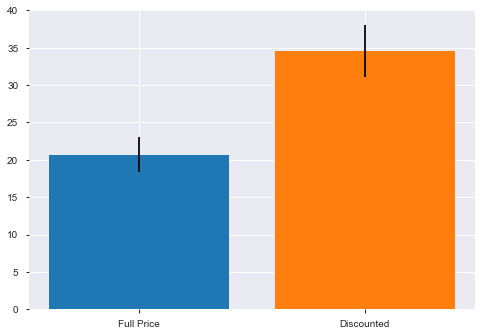


Results for Denmark:
Ttest_indResult(statistic=0.16182691149215328, pvalue=0.8721830022491708)

Denmark has no preference.


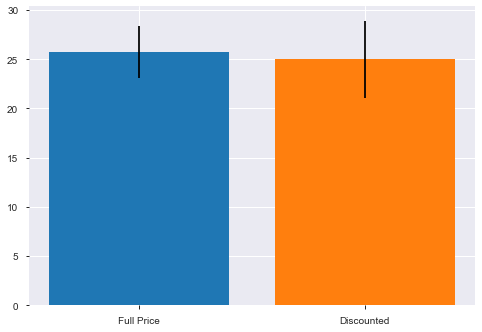


Results for Finland:
Ttest_indResult(statistic=-0.8608852977352008, pvalue=0.39325342251232176)

Finland has no preference.


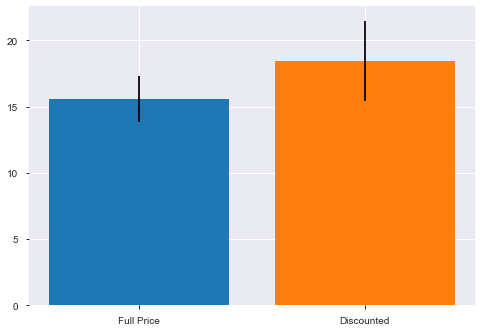


Results for France:
Ttest_indResult(statistic=-0.9806435498249095, pvalue=0.32807031410690046)

France has no preference.


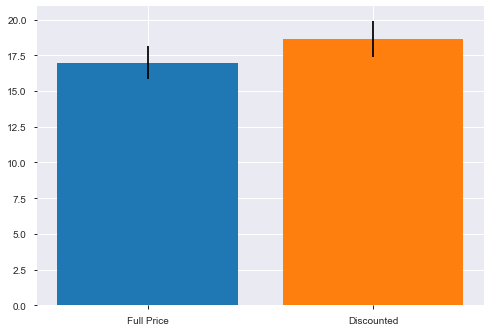


Results for Germany:
Ttest_indResult(statistic=-1.8173101934160463, pvalue=0.07008759031616896)

Germany has no preference.


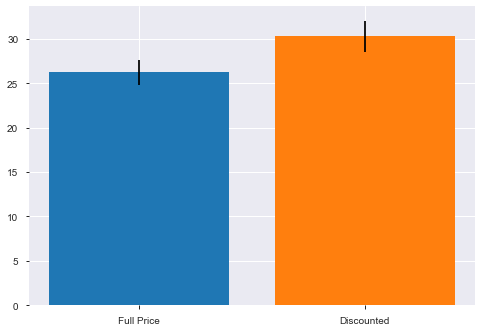


Results for Ireland:
Ttest_indResult(statistic=-0.7429260971205413, pvalue=0.4608068502897392)

Ireland has no preference.


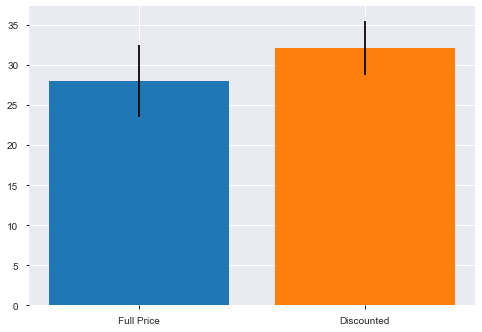


Results for Italy:
Ttest_indResult(statistic=-0.7780531564455361, pvalue=0.44013244003386054)

Italy has no preference.


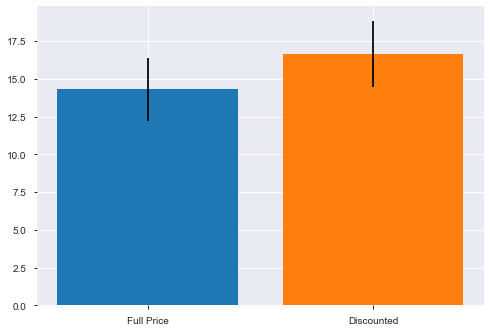


Results for Mexico:
Ttest_indResult(statistic=-1.3194239082443096, pvalue=0.19132685241353548)

Mexico has no preference.


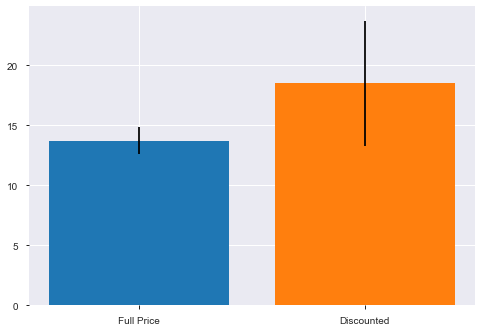

Norway is missing one of the groups.
Poland is missing one of the groups.

Results for Portugal:
Ttest_indResult(statistic=0.5600940599048722, pvalue=0.5798692487056942)

Portugal has no preference.


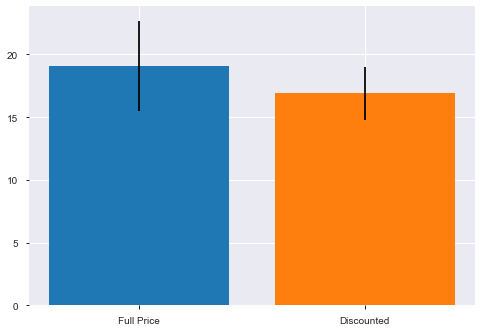


Results for Spain:
Ttest_indResult(statistic=-3.1763643150718117, pvalue=0.0025087181106716217)

Spain prefers discounts!


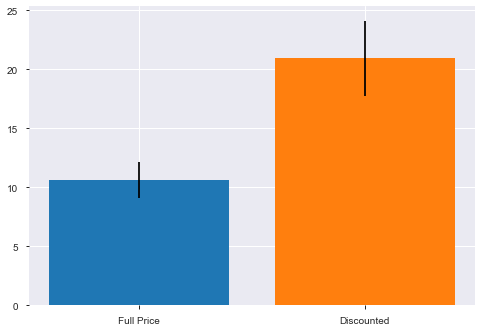


Results for Sweden:
Ttest_indResult(statistic=-1.2562000199627796, pvalue=0.21212390207789034)

Sweden has no preference.


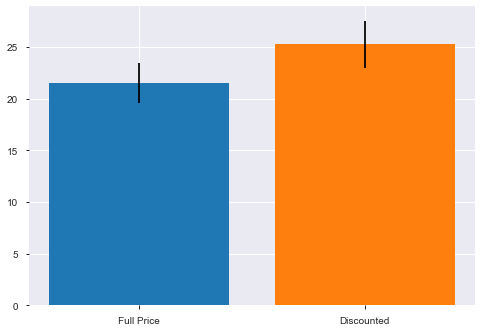


Results for Switzerland:
Ttest_indResult(statistic=-0.10239875784840313, pvalue=0.918849747200548)

Switzerland has no preference.


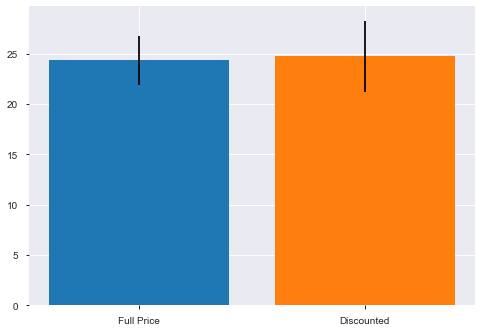


Results for UK:
Ttest_indResult(statistic=-3.696969710034723, pvalue=0.00031794803200322925)

UK prefers discounts!


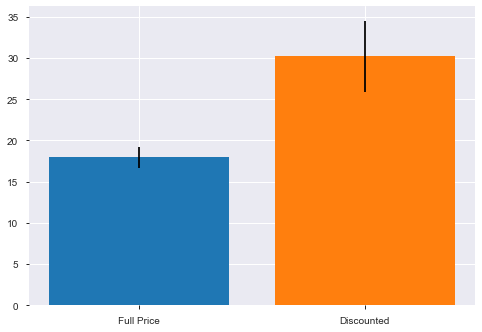


Results for USA:
Ttest_indResult(statistic=-2.339550039669184, pvalue=0.019868707223971476)

USA prefers discounts!


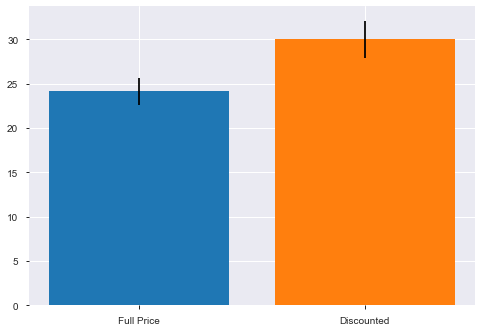


Results for Venezuela:
Ttest_indResult(statistic=-0.053460536854696136, pvalue=0.9574569329239815)

Venezuela has no preference.


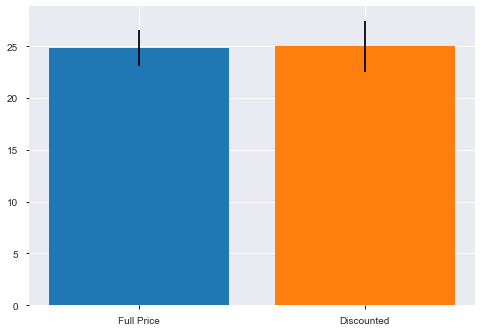

In [96]:
# Check if sample sizes allow us to ignore assumptions; if not, test normality assumption
# visualize sample size comparisons for two groups (normality check)
for k,v in grps.items():
    try:
        grp0 = df.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df.loc[v].groupby('discounted').get_group(1)['Quantity']
        print(f"\nResults for {k}:")
        result = stat.ttest_ind(grp0,grp1)
        print(result)
        if result[1] < 0.05:
            print(f"\n{k} prefers discounts!")
        else:
            print(f"\n{k} has no preference.")
        
        import scipy.stats as stat
        plt.bar(x='Full Price', height=grp0.mean(),
               yerr=stat.sem(grp0))
        plt.bar(x='Discounted', height=grp1.mean(),
               yerr=stat.sem(grp1))
        plt.show()
    
    except:
        print(f"{k} is missing one of the groups.")

In [91]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Quantity~C(discounted)+C(ShipCountry)+C(discounted):C(ShipCountry)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)
/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(discounted),9.780918e-08,1.0,3.075567e-10,9.999860e-01
C(ShipCountry),1.013469e+05,20.0,1.593405e+01,6.897563e-47
C(discounted):C(ShipCountry),1.558486e+04,20.0,2.450296e+00,6.127527e-04
Residual,6.729302e+05,2116.0,NaN,NaN


Although discount does not have a significant effect on countries overall (p = 0.99), in certain countries there does appear to be a statistically significant relationship between order quantities and discount.

Countries showing a preference for discount include:
* Spain
* UK
* Canada
* USA

We were able to verify this by doing a normality check for each in the plots above.


In [116]:
 
# insert column indicating countries that prefer a discount
df['DiscPref'] = np.where(df[df.ShipCountry.isin(['Spain', 'UK', 'USA', 'Canada'])] == 1)
df.head()

ValueError: Length of values does not match length of index

In [98]:
#!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.

q1 = "SELECT Quantity, Discount, Count(*) from df where Country = 'Spain' and Discount > 0 group by 1;"
q2 = "SELECT Quantity, Sum(*) from df where Country = 'Spain' and Discount = 0 group by 1;"

discount_df = pysqldf(q1)
fullprice_df = pysqldf(q2)

# Create and label the histograms for each below!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

discount_df.set_index('Discount')['Count(*)'].plot(kind='barh', ax=axes[0])
axes[0].set_title('Distribution of Discount Orders for Spain')

fullprice_df.set_index('Discount')['Count(*)'].plot(kind='barh', ax=axes[1])
axes[1].set_title('Distribution of Classes for Female Casualties')

In [ ]:

# Check if sample sizes allow us to ignore assumptions; if not, test assumption normality
# visualize sample size comparisons for two groups (normality check)
# Select appropriate t-test based on assumptions of normality and homogeneity of variance
# Test for normality
stat.normaltest(fullprice), stat.normaltest(discount)
stat.mannwhitneyu(fullprice, discount)
# Test for homogeneity of variance
# Run non-parametric test (if normality test failed)
# Perform chosen statistical test, calculate effect size, and any post-hoc tests.

# run tukey test for OQD (Order Quantity Discount) 
data = df_orderDetail['Quantity'].values
labels = df_orderDetail['Discount'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

# Plot a universal confidence interval of each group mean comparing significant differences in group means. 
# Significant differences at the alpha=0.05 level can be identified by intervals that do not overlap 

oq_data = df_orderDetail['Quantity'].values
discount_labels = df_orderDetail['Discount'].values

from statsmodels.stats.multicomp import MultiComparison
oqd = MultiComparison(oq_data, discount_labels)
results = oqd.tukeyhsd()
results.plot_simultaneous(comparison_name=0.2, xlabel='order qty', ylabel='discount level')

In [93]:
usa = df.loc[grps['USA']].groupby('discounted').describe()
usa

OrderId                                                       \
             count          mean         std      min      25%      50%   
discounted                                                                
0            210.0  10698.752381  242.908248  10262.0  10532.0  10687.0   
1            142.0  10691.028169  247.935531  10262.0  10472.5  10700.0   

                             ProductId             ... ShipVia      Freight  \
                75%      max     count       mean  ...     75%  max   count   
discounted                                         ...                        
0           10887.5  11077.0     210.0  40.533333  ...     3.0  3.0   210.0   
1           10884.0  11077.0     142.0  39.661972  ...     3.0  3.0   142.0   

                                                                        
                  mean         std   min    25%    50%     75%     max  
discounted                                                              
0           128.309524  168.849717  0.20  14.91  52.41  170.97  830.75  
1           135.357887  177.086631  3.35  26.61  73.21  141.16  830.75  

[2 rows x 64 columns]

In [ ]:
sns.distplot(grp0)
sns.distplot(grp1)

In [ ]:
anova_table.style.format("{:.4f}", subset=['PR(>F)'])

## Results

In [ ]:
# create dataframe from OrderDetail table since that is where the discount information is stored
cur.execute("""SELECT * FROM OrderDetail;""")
df_orderDetail = pd.DataFrame(cur.fetchall())
df_orderDetail.columns = [x[0] for x in cur.description]
df_orderDetail.head()

# split order data into two groups: discounted and fullprice
fullprice = df_orderDetail.groupby('discounted').get_group(0)['Quantity']
discount = df_orderDetail.groupby('discounted').get_group(1)['Quantity']

# insert boolean column into orderDetail showing whether or not an order includes a discount value
df_orderDetail['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)


In [215]:
prod_price = df_oqd[{'ProductId', 'UnitPrice', 'Quantity'}]
prod_price.set_index('ProductId', inplace=True)
prod_price

,UnitPrice,Quantity
ProductId,,
51,42.4,35
65,16.8,15
22,16.8,6
57,15.6,15
20,64.8,40
...,...,...
2,19.0,24
7,30.0,1
8,40.0,2


In [222]:
# use numpy broadcasting to calculate revenue of orders : unitprice * quantity for each of the sig disc levels

prod_price['OrderPrice'] = prod_price.UnitPrice * prod_price.Quantity
prod_price

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,UnitPrice,Quantity,OrderPrice
ProductId,,,
51,42.4,35,1484.0
65,16.8,15,252.0
22,16.8,6,100.8
57,15.6,15,234.0
20,64.8,40,2592.0
...,...,...,...
2,19.0,24,456.0
7,30.0,1,30.0
8,40.0,2,80.0


In [186]:
df_oqd['UnitPrice'].unique()

array([ 42.4 ,  16.8 ,  15.6 ,  64.8 ,   2.  ,   3.6 ,  19.2 ,  15.2 ,
        17.  ,  25.6 ,   7.7 ,  39.4 ,  12.  ,  13.9 ,  20.7 ,   8.  ,
        30.4 ,  44.  ,  14.4 ,  27.8 ,  24.8 ,  10.  ,  14.7 ,  31.2 ,
        35.1 ,  27.2 ,  11.2 ,  26.2 ,   9.6 ,   5.9 ,   4.8 ,  15.5 ,
        50.  ,  99.  ,  10.6 ,   7.3 , 210.8 ,  24.9 ,   7.6 ,  17.2 ,
        17.6 ,  36.8 ,  32.  ,   6.2 ,  13.  ,  28.8 ,  36.4 ,  26.6 ,
        24.  ,   5.6 ,  18.6 ,  10.2 ,  16.  ,  77.6 ,  10.4 ,  22.8 ,
        13.6 ,  45.6 ,  14.  ,  15.  ,  46.  ,  12.75,   7.75,  22.  ,
        30.  ,  40.  ,   4.5 ,   9.5 ,  34.  ,  28.5 ,  97.  ,   2.5 ,
        62.5 ,   9.65,  31.  ,  18.  ,  25.89,  18.4 ,  39.  ,  81.  ,
        26.  ,  38.  ,  19.  ,   7.45,  21.  ,  19.5 ,  55.  , 263.5 ,
        21.05,  21.5 ,   9.  ,  12.5 ,  53.  ,  17.45,  49.3 ,  23.25,
         9.2 ,  33.25,  36.  ,   7.  ,  31.23,  43.9 ,  20.  ,   6.  ,
        21.35,  16.25,  32.8 ,  19.45,  13.25, 123.79,  34.8 ,  25.  ])

In [85]:
df_employees = get_table(cur, table="'employee'")
df_product = get_table(cur, table="'Product'")
df_product.head(2)
df_order = get_table(cur, table="'Order'")
df_order.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0


In [ ]:


from scipy.stats import sem
fig, ax = plt.subplots(figsize=(2,6))
ax.bar(group1['name'],group1['data'].mean(), yerr=sem(group1['data']))

ax.bar(group2['name'],group2['data'].mean(), yerr=sem(group2['data']))

In [2]:
from scipy import stats

def print_normtest(x,label=None,as_series=False):
    """Runs scipy.stats.normaltest and prints results,
    may also return them if as_series=True
    """
    if label is None:
        try:
            label=x.name
        except:
            label=''

    results = ['Survived','Norm Stat','p value','(p<0.05)']

    out = stats.normaltest(x)

    values = [label, out.statistic.round(3),
              out.pvalue.round(4), out.pvalue<0.05]

    results=dict(zip(results,values))

    print(f"\n--- stats.normtest results:")
    [print(f"{k:{15}} : {v}")for k,v in results.items()]
    
    if as_series:
        return pd.Series(results)

In [1]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

NameError: name 'group1' is not defined

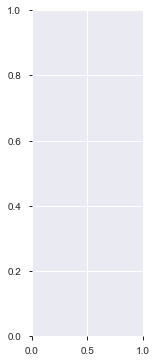

In [16]:
from scipy.stats import sem
fig, ax = plt.subplots(figsize=(2,6))
ax.bar(group1['name'],group1['data'].mean(), yerr=sem(group1['data']))

ax.bar(group2['name'],group2['data'].mean(), yerr=sem(group2['data']))

In [ ]:
SELECT * from OrderDetail 
WHERE Discount > 0
ORDER BY OrderId;

In [ ]:


cur.execute("""SELECT customerName,
               COUNT(amount) AS number_purchases_over_50K
               FROM customers
               JOIN payments
               USING(customerNumber)
               WHERE amount >= 50000
               GROUP BY 1
               HAVING count(amount) >= 3
               ORDER BY count(amount) DESC;""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()

In [ ]:
cur.execute("""SELECT city, COUNT(customerNumber) AS number_customers
               FROM customers
               GROUP BY 1
               HAVING COUNT(customerNumber)>=5;""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()

# H3: Time of Year and Revenue/Units Sold
* Does time of year have a statistically significant effect on sales? 
* If so, which months/seasons? Does this vary by region/country?

## Hypotheses
    
    𝐻1  : Discount amount has a statistically significant effect on the quantity in an order.

    𝐻0 : Discount amount has no relationship with the quantity of a product in an order.

## Data Grouping

       * average number of orders made
       * average order size (measured as quantities per order)

In [117]:
pd.to_datetime(df['OrderDate']).head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [119]:
pd.to_datetime(df['OrderDate'], format='%Y/%m/%d').head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [128]:
#df['year'] = df['ArrivalDate'].dt.year
df['OrderMonth'] = pd.DatetimeIndex(df['OrderDate']).month
df['OrderYear'] = pd.DatetimeIndex(df['OrderDate']).year
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,CustomerId,EmployeeId,OrderDate,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,0,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,0,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,0,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,0,TOMSP,6,2012-07-05,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,0,TOMSP,6,2012-07-05,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


In [129]:
df.OrderMonth.value_counts()

4     261
3     255
1     237
2     201
12    195
10    179
11    155
5     155
8     153
9     152
7     136
6      76
Name: OrderMonth, dtype: int64

In [137]:
#sum(df[df.OrderMonth == 1].Quantity)
# January: 5867 order quantity

qty_per_month = {}


for i in list(range(1,13)):
    qty = sum(df[df.OrderMonth == i].Quantity)
    qty_per_month[i] = qty


qty_per_month

{1: 5867,
 2: 5247,
 3: 5835,
 4: 6592,
 5: 3085,
 6: 1635,
 7: 3516,
 8: 3183,
 9: 3467,
 10: 4417,
 11: 3591,
 12: 4882}

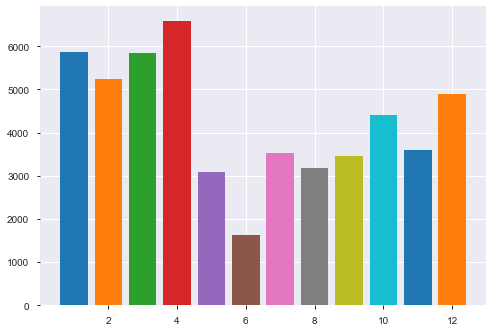

In [142]:
for k,v in qty_per_month.items():
    plt.bar(x=k, height=v)

In [ ]:

    c. Testing
    d. Results
cur.execute("""SELECT Region, Country, ProductId, UnitPrice, Quantity, Discount
               FROM Customer
               JOIN 'Order'
               USING(CustomerId)
               JOIN OrderDetail
               USING(Id)
               ORDER BY Country DESC;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
print('Total number of results:', len(df))
df.head()

## Testing

## Results